# Test

This will be some testing to see that everything gives us the results that we expect. 

## Dependencies

In [2]:
import sys 
sys.path.append("..")

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass 
from physics.fom import sensitivity, sfm, mcf, tsf 
from physics.reflectometry import _kz, reflectivity

from problems.base1 import Bounds, SOISpec, CapSpec, MRL, Materials, Base1OptimizationProblem, SubstrateSpec, MRL


/Users/michaelbirtman/dev/Optimization-of-Magnetic-Reference-Layer/src/Notebooks/../problems/base1.py:67: SyntaxWarning: invalid escape sequence '\i'
  # x_coti \in [0,1]
/Users/michaelbirtman/dev/Optimization-of-Magnetic-Reference-Layer/src/Notebooks/../problems/base1.py:119: SyntaxWarning: invalid escape sequence '\i'
  - x_coti \in [bounds_x.lo, bounds_x.hi]


# Testing Data 

In [4]:
materials = Materials(
    substrate=SubstrateSpec(name="Si", rho_n=2.07, sigma=3.0),
    caps={
        "Al2O3": CapSpec("Al2O3", rho_n=5.7, thickness=16.0, sigma=8.0),
        "SiO2":  CapSpec("SiO2",  rho_n=3.47, thickness=16.0, sigma=8.0),
        "Au":    CapSpec("Au",    rho_n=4.5, thickness=16.0, sigma=8.0),
    },
    mrl=MRL(
        rho_n_Co=2.265,
        rho_n_Ti=-1.95,
        m_sld_from_x=lambda x: 1 * x,  #test
        sigma_sub_mrl=5.0,
        sigma_mrl_cap=5.0,
    ),
)

# testing not real material 
# same as in paper 
soi_list = [
    # normal, 500 Å, sigma = 15 Å
    SOISpec("normal_1", rho_n=1.0, thickness=500.0, sigma=15.0),
    SOISpec("normal_2", rho_n=2.0, thickness=500.0, sigma=15.0),
    SOISpec("normal_3", rho_n=3.0, thickness=500.0, sigma=15.0),

    # rough, 500 Å, sigma = 50 Å
    SOISpec("rough_1", rho_n=1.0, thickness=500.0, sigma=50.0),
    SOISpec("rough_2", rho_n=2.0, thickness=500.0, sigma=50.0),
    SOISpec("rough_3", rho_n=3.0, thickness=500.0, sigma=50.0),

    # thin, 50 Å, sigma = 15 Å
    SOISpec("thin_1", rho_n=1.0, thickness=50.0, sigma=15.0),
    SOISpec("thin_2", rho_n=2.0, thickness=50.0, sigma=15.0),
    SOISpec("thin_3", rho_n=3.0, thickness=50.0, sigma=15.0),
]


# Create a Q grid 
Q = np.linspace(0.005, 0.25, 1200)

# define problem 

problem = Base1OptimizationProblem(
    materials=materials,
    soi_list=soi_list,
    q_grid=Q,
    bounds_x=Bounds(0.0, 1.0),
    bounds_d=Bounds(20.0, 300.0),
    weight_fn=None,
)


TypeError: CapSpec.__init__() got an unexpected keyword argument 'thickness'

# Eval and testing 

{'value': 0.27998455647326587, 'per_soi': [{'soi': 'SOI_lowSLD', 'SFM_up': 0.04715168531950439, 'SFM_down': 0.04380803979055468, 'MCF': 0.01782273604974831}, {'soi': 'SOI_midSLD', 'SFM_up': 0.04931589809711859, 'SFM_down': 0.04274144382626241, 'MCF': 0.016062368571444455}, {'soi': 'SOI_highSLD', 'SFM_up': 0.029698447727484163, 'SFM_down': 0.022639931810448342, 'MCF': 0.010744005280700518}]}


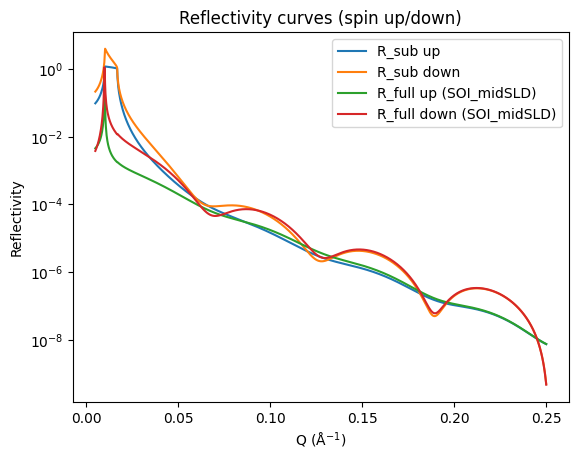

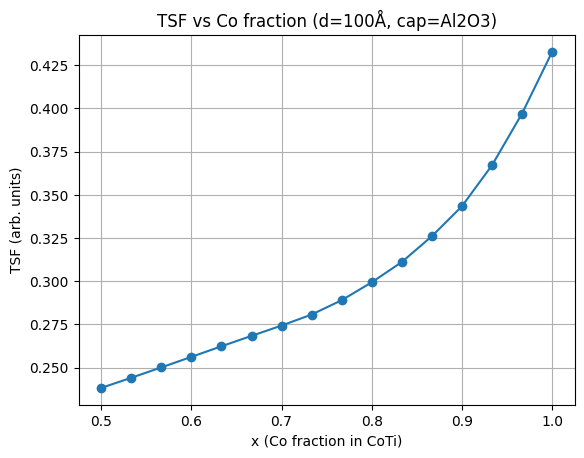


TSF by cap @ (x=0.73, d=100Å):
  Al2O3: 0.279985
  SiO2: 0.269982
  Au: 0.248811


In [ ]:
res = problem.evaluate_objective(x_coti=0.73, d_mrl=100.0, cap="Al2O3", return_breakdown=True)
print(res)

#  reflectivity curves for one SOI
soi_example = soi_list[1]  
L_sub_up, L_sub_dn  = problem._layers(0.73, 100.0, "Al2O3", soi=None)
L_full_up, L_full_dn = problem._layers(0.73, 100.0, "Al2O3", soi=soi_example)

Rsub_up = reflectivity(Q, L_sub_up)
Rsub_dn = reflectivity(Q, L_sub_dn)
Rfull_up = reflectivity(Q, L_full_up)
Rfull_dn = reflectivity(Q, L_full_dn)

plt.figure()
plt.plot(Q, Rsub_up, label="R_sub up")
plt.plot(Q, Rsub_dn, label="R_sub down")
plt.plot(Q, Rfull_up, label=f"R_full up ({soi_example.name})")
plt.plot(Q, Rfull_dn, label=f"R_full down ({soi_example.name})")
plt.yscale("log")
plt.xlabel("Q (Å$^{-1}$)")
plt.ylabel("Reflectivity")
plt.legend()
plt.title("Reflectivity curves (spin up/down)")
plt.show()

xs = np.linspace(0.5, 1.0, 16)
tsf_vals = [problem.evaluate_objective(x, 100.0, "Al2O3") for x in xs]

plt.figure()
plt.plot(xs, tsf_vals, marker="o")
plt.xlabel("x (Co fraction in CoTi)")
plt.ylabel("TSF (arb. units)")
plt.title("TSF vs Co fraction (d=100Å, cap=Al2O3)")
plt.grid(True)
plt.show()

# Compare caps
caps = list(materials.caps.keys())
vals_by_cap = {c: problem.evaluate_objective(0.73, 100.0, c) for c in caps}

print("\nTSF by cap @ (x=0.73, d=100Å):")
for c, v in vals_by_cap.items():
    print(f"  {c}: {v:.6f}")